# Exercise 7 | Principle Component Analysis and K-Means Clustering

# ex7.m

# ===== Part 1: Find Closest Centroids =====

In this this exercise, We will implement the K-means algorithm and use it for image compression. We will first start on an example 2D dataset that will help us gain an intuition of how the K-means algorithm works. After that, we wil use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, we are given a training set ${x(1)......x(m)}$ (where x(i) is an element of Rn), and want to group the data into a few "cohesive clusters"

The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

In [27]:
# Loading an example dataset that we will be using

# Importing important libraries
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt
import seaborn as sns
# Used for reading data and data manipulation
import pandas as pd 

# Optimization module in scipy
import scipy.io as sio

os.getcwd()
data = sio.loadmat('../DataSets/Exercise-7/ex7data2.mat')
X = data['X']

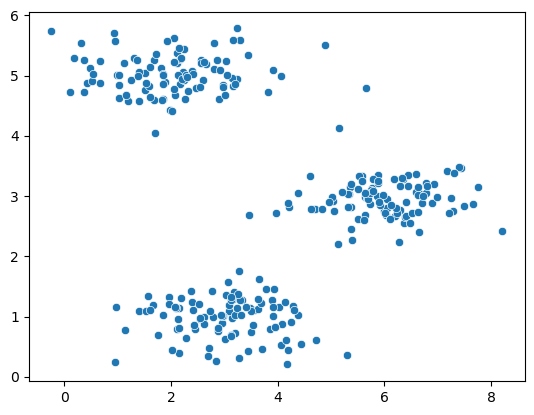

In [28]:
# plotting the data
sns.scatterplot(x=X[:,0],y=X[:,1]);

In [29]:
# Selecting an initial set of centroids
K = 3
initial_centroids = [(3, 3), (6, 2), (8, 5)]
X_df = pd.DataFrame(X, columns=['x1','x2'])
K = 3
cluster_names = ['K_' + str(i+1) for i in range(K)]
colors = ['red', 'green', 'blue']
cluster_names_colors = [('K_' + str(i+1), colors[i]) for i in range(K)]
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

In [30]:
X_df

,x1,x2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894
...,...,...
295,7.302787,3.380160
296,6.991984,2.987067
297,4.825534,2.779617
298,6.117681,2.854757


In [31]:
initial_centroids

array([[3, 3],
       [6, 2],
       [8, 5]])

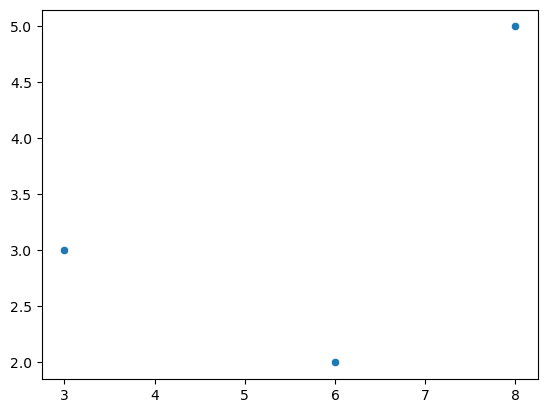

In [32]:
# plotting the initial centroids
sns.scatterplot(x=initial_centroids[:,0],y=initial_centroids[:,1]);

In [33]:
cluster_names_colors

[('K_1', 'red'), ('K_2', 'green'), ('K_3', 'blue')]

In [34]:
# Finding the closest centroids for the examples using the initial_centroids

def find_closest_centroids(X_df, initial_centroids):
    num_centroids = len(initial_centroids)
    # compute the euclidian distance of each data point from each of the centroids and store it in a column of dataframe
    for i in range(num_centroids):
        col_name = 'K_' + str(i+1)
        X_df[col_name] = ((X_df['x1'] - initial_centroids[i, 0]) ** 2) + ((X_df['x2'] - initial_centroids[i, 1]) ** 2)
    # for each data point ( row in dataframe ) compare the distance from each centroid and assign the data point
    # to centroid with minimum distance
    if 'cluster' in X_df.columns:
        X_df['cluster'] = X_df.iloc[:, 2:-1].idxmin(axis=1)
    else:
        X_df['cluster'] = X_df.iloc[:, 2:].idxmin(axis=1)
    
find_closest_centroids(X_df, initial_centroids)
print('The first three examples belong to the clusters')
print(X_df['cluster'][0:3].values.tolist())

The first three examples belong to the clusters
['K_1', 'K_3', 'K_2']


# ===== Part 2: Compute Means =====

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it.


In [35]:
def compute_centroids(X_df, cluster_names_colors):
    new_centroids = {}
    for cluster_name_color in cluster_names_colors:
        cluster_df = X_df[X_df['cluster'] == cluster_name_color[0]]
    new_centroids[cluster_name_color[0]] = [cluster_df['x1'].mean(), cluster_df['x2'].mean()]
    return new_centroids

new_centroids = compute_centroids(X_df, cluster_names_colors)
print('Location of centroids computed after first iteration:')
print(new_centroids)

Location of centroids computed after first iteration:
{'K_3': [7.1193868715087545, 3.6166843987216186]}


# ===== Part 3: K-Means Clustering =====

We will now run a number of iteration of k-means and plot the data points belonging to three clusters red, green and blue. We will also plot the centroid of each cluster. Notice how the clustering on points and the centroid locations change with each iteration and iteration 6 onwards the change become negligible.

In [36]:
def plot_data(X_df, cluster_names_colors, centroids, iter_count):
    fig, ax = plt.subplots()
    for cluster_name_color in cluster_names_colors:
        cluster_df = X_df[X_df['cluster'] == cluster_name_color[0]]
        ax.scatter(cluster_df['x1'], cluster_df['x2'], marker='o', color=cluster_name_color[1])
        ax.plot(centroids[cluster_name_color[0]][0], centroids[cluster_name_color[0]][1], '-Xk', ms=10, lw=2, mew=2)
    ax.set_title('Data points clustering at iteration: {}'.format(iter_count))
    plt.show()


def run_kmeans(X_df, initial_centroids, num_iterations):
    centroids = initial_centroids
    for iter_count in range(num_iterations):
        find_closest_centroids(X_df, centroids)
        new_centroids = compute_centroids(X_df, cluster_names_colors)
        plot_data(X_df, cluster_names_colors, new_centroids, iter_count)
        centroids = np.array(list(new_centroids.values()))

KeyError: 'K_1'

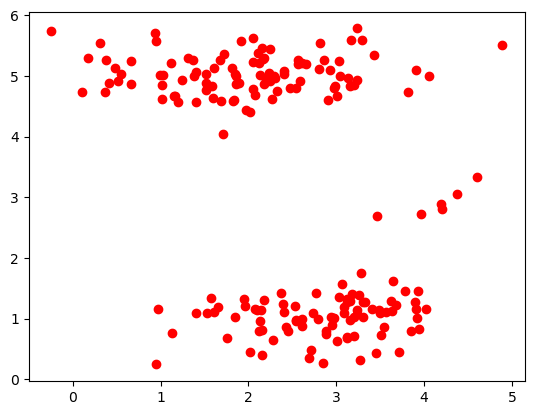

In [37]:
run_kmeans(X_df, initial_centroids, 10)

# ex7.m => bird_small.mat

# ===== Part 4: K-Means Clustering on Pixels =====

**Image compression using KMeans**  
In this exercise, we will apply K-means to image compression. In a straightforward 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. 

This encoding is often refered to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, we will reduce the number of colors to 16 colors. By making this reduction, it is possible to represent (compress) the photo in an efficient way. 

Specifically, we only need to store the RGB values of the 16 selected colors, and for each pixel in the image we now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities). In this exercise, we will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Concretely, we will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3- dimensional RGB space. Once we have computed the cluster centroids on the image, we will then use the 16 colors to replace the pixels in the original image.

**Load 128x128 color image (bird_small.png)**  
This creates a three-dimensional matrix A whose first two indices identify a pixel position and whose last index represents red, green, or blue. For example, A(50, 33, 3) gives the blue intensity of the pixel at row 50 and column 33.

In [38]:
image_data = sio.loadmat('../DataSets/Exercise-7/bird_small.mat')
X_image = image_data['A']
dim = X_image.shape
# Reshape the image data to create a mx3 matrix of pixel colors where m is the number of pixels ( 128 * 128 )
X_image_reshaped = X_image.reshape(-1, 3)
# The mx3 numpy matrix is loaded as a dataframe
X_image_df = pd.DataFrame(X_image_reshaped, columns=['R','G','B'], dtype=np.int32)
data_columns = X_image_df.columns.values
# number of clusters ( here number of colors to paint an image )
K = 16
max_iters = 10
num_data_cols = 3

In [39]:
image_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Jun  5 04:06:24 2012',
 '__version__': '1.0',
 '__globals__': [],
 'A': array([[[219, 180, 103],
         [230, 185, 116],
         [226, 186, 110],
         ...,
         [ 14,  15,  13],
         [ 13,  15,  12],
         [ 12,  14,  12]],
 
        [[230, 193, 119],
         [224, 192, 120],
         [226, 192, 124],
         ...,
         [ 16,  16,  13],
         [ 14,  15,  10],
         [ 11,  14,   9]],
 
        [[228, 191, 123],
         [228, 191, 121],
         [220, 185, 118],
         ...,
         [ 14,  16,  13],
         [ 13,  13,  11],
         [ 11,  15,  10]],
 
        ...,
 
        [[ 15,  18,  16],
         [ 18,  21,  18],
         [ 18,  19,  16],
         ...,
         [ 81,  45,  45],
         [ 70,  43,  35],
         [ 72,  51,  43]],
 
        [[ 16,  17,  17],
         [ 17,  18,  19],
         [ 20,  19,  20],
         ...,
         [ 80,  38,  40],
         [ 68,  39,  40],
     

In [40]:
#X SHAPE 
X_image_reshaped

array([[219, 180, 103],
       [230, 185, 116],
       [226, 186, 110],
       ...,
       [ 65,  43,  39],
       [ 58,  37,  38],
       [ 52,  39,  34]], dtype=uint8)

In [41]:
# IMAGE DIMENSION
dim

(128, 128, 3)

**Display the original image**

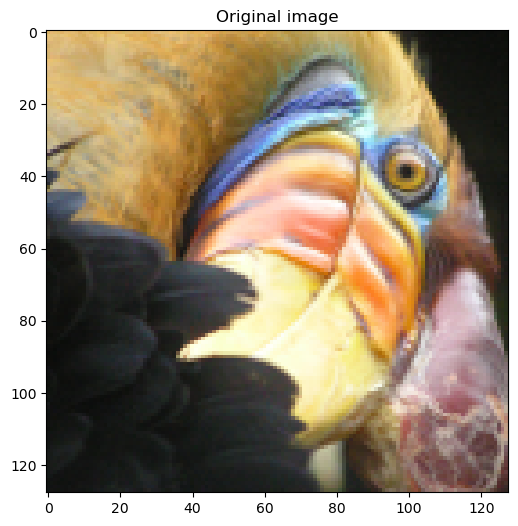

In [42]:
def display_image(image_data, title):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.set_title(title)
    ax.imshow(image_data)

display_image(X_image, 'Original image')   

Select K centroids ( pixels ) randomly as initial centroids

In [43]:
def get_random_initial_centroids(X, K):
    random_indices = np.random.choice(X.shape[0], size=K)
    random_initial_centroids = X[random_indices, :]
    return random_initial_centroids

initial_centroids = get_random_initial_centroids(X_image_reshaped, K)

In [44]:
get_random_initial_centroids(X, 16)

array([[6.92721968, 3.19960026],
       [1.12036737, 5.20880747],
       [3.54010186, 0.86446135],
       [1.36678395, 5.26161095],
       [2.59148642, 4.92593394],
       [6.33559522, 3.30864291],
       [5.57812294, 3.24766016],
       [4.20584789, 2.81647368],
       [2.54371489, 0.95732716],
       [2.90401653, 4.61220411],
       [3.45928006, 2.68478445],
       [3.43493543, 5.34080741],
       [2.95818429, 1.01887096],
       [0.41852373, 4.88312522],
       [0.41852373, 4.88312522],
       [5.89562099, 2.89843977]])

# ===== Part 5: Image Compression =====

After finding the top K = 16 colors to represent the image, we can now assign each pixel position to its closest centroid using the findClosestCentroids function. This allows us to represent the original image using the centroid assignments of each pixel. Notice that we have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each one of the 128 by 128 pixel locations, resulting in total size of 128 by 128 by 24 = 393,216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16 24 + 128 128 * 4 = 65, 920 bits, which corresponds to compressing the original image by about a factor of 6.

In [45]:
def find_closest_centroids(X_df, initial_centroids, num_data_cols):
    num_centroids = len(initial_centroids)
    # compute the euclidian distance of each data point from each of the centroids and store it in a 
    # column of dataframe
    for i in range(num_centroids):
        col_name = i
        initial_centroid_matrix = np.tile(initial_centroids[i], (len(X_df), 1))
        X_df[col_name] = np.sqrt(np.sum(np.square(X_df.iloc[:, 0:num_data_cols].values - initial_centroid_matrix), 
                                        axis=1))
    # for each data point ( row in dataframe ) compare the distance from each centroid and assign the data point
    # to centroid with minimum distance
    if 'cluster' in X_df.columns:
        X_df['cluster'] = X_df.iloc[:, num_data_cols:-1].idxmin(axis=1)
    else:
        X_df['cluster'] = X_df.iloc[:, num_data_cols:].idxmin(axis=1)
    return X_df

def compute_centroids(X_df, data_col_names, clusters):
    new_centroids = []
    for cluster in clusters:
        cluster_df = X_df[X_df['cluster'] == cluster]
        new_centroids.append([cluster_df[data_col_name].mean() for data_col_name in data_col_names])
    return np.array(new_centroids).astype('int32')


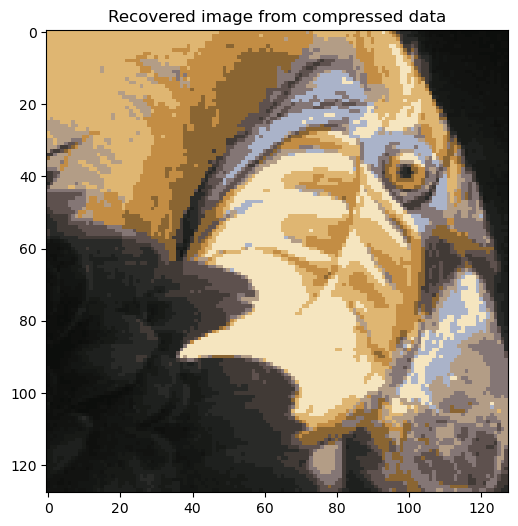

In [47]:
def run_kmeans(X_df, data_cols, initial_centroids, clusters, num_iterations):
    centroids = initial_centroids
    for iter_count in range(num_iterations):
        X_df = find_closest_centroids(X_df, centroids, len(data_cols))
        centroids = compute_centroids(X_df, data_cols, clusters)
    # the cluster column contains one of the K cluster values that each data point belongs to. In our
    # image compression example, this means that each pixel can be represent using a 16 bit short int
    # instead of the [R G B] array wherein each element represents a color intensity in 8 bits (0-255)
    # It is this compressed image representation ( a 128 by 128 array) that we return after running the kmeans
    return X_df['cluster'].values.reshape(128, 128), centroids

def uncompress_image_data(X_image_compressed, final_centroids):
    recovered_image = []
    for row in range(X_image_compressed.shape[0]):
        recovered_image_row = []
        for col in range(X_image_compressed.shape[1]):
            index = X_image_compressed[row][col]
            recovered_image_row.append(list(final_centroids[index]))
        recovered_image.append(recovered_image_row)
    return np.array(recovered_image)

X_image_reshaped = find_closest_centroids(X_image_df, initial_centroids, num_data_cols)
X_image_compressed, final_centroids = run_kmeans(X_image_reshaped, data_columns, initial_centroids, np.arange(K), max_iters)
X_image_recovered = uncompress_image_data(X_image_compressed, final_centroids)
display_image(X_image_recovered, 'Recovered image from compressed data')

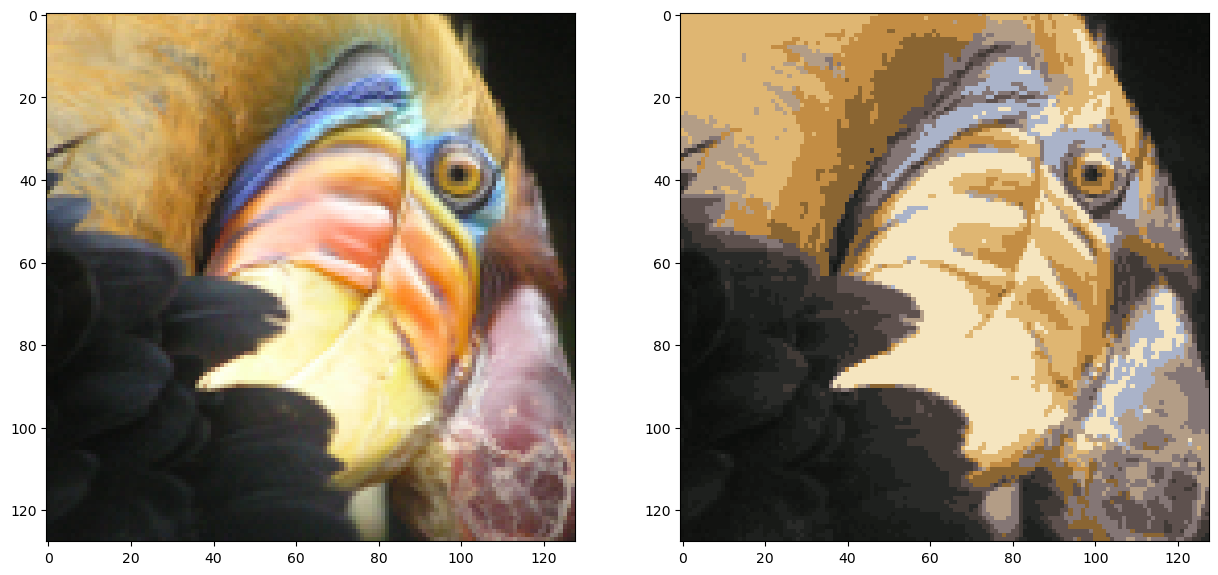

In [48]:
# Displaying the original image and compressed image side by side
fig, ax = plt.subplots(1, 2, figsize=(15,8))
ax[0].imshow(X_image)
ax[1].imshow(X_image_recovered)
plt.show()